Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/04/28


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Delicious Classification


## Question:
How well can Support Vector Machine perform Classification on recipe ratings? 

What we want to see is if we can use the ingredients, nutritional information and keyword list to predict the rating.


### Data:
Data set is drawn from the larger epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

The dataset can be [found on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes).


### Context:
For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

### Content:
Over 20k recipes listed by recipe rating, nutritional information and assigned category (sparse). Dataset contains 680 features.


In [12]:
# Read CSV containing text data
data_file = '/media/ianh/space/ThinkfulData/Epicurious/epi_r.csv'
recipes = pd.read_csv(data_file)
print("\nObservations : %d" % (recipes.shape[0]))


Observations : 20052


## Preprocessing and exploratory data analysis

In [13]:
# Count nulls of features
null_count = recipes.isnull().sum()
null_count[null_count > 0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

These fours features have a lot of missing data points. Our next question is, are these missing data points mostly within the same observations (same data frame index) or scatter throughout the data set?
Our bodies are genetically drawn to food with higher portions of fat and protein so therefore retaining these features would perhaps help our model to classify recipe ratings. 

In [14]:
# adding indices of missing feature data into a Set to asses the dispersion of of missing data across 
# the entire data set
big_mask = recipes.isnull()
unique_rows = set(list(big_mask[big_mask.calories == True].index.values))
unique_rows.update(list(big_mask[big_mask.protein == True].index.values))
unique_rows.update(list(big_mask[big_mask.fat == True].index.values))
unique_rows.update(list(big_mask[big_mask.sodium == True].index.values))
print('\nThe missing data for the 4 features are roughly confined to the same %d indices' % (len(unique_rows)))


The missing data for the 4 features are roughly confined to the same 4188 indices


As we add the index values of the masks representing those cells where one of the features has a null value into the Set we are determining how distributed the missing data points of these observations are.  If the missing data is quite dispersed we will need to the drop the features from the data frame. 

With 4188 missing data points we can still use the four features if we are willing to settle for 15,864 observations to drive our Support Vector Machine.

### Feature Selection

There are features with state names, those with column names starting with ‘#’ and others with dubious labels that may hold very little information, perhaps not worth the increased time in computation and the high bias in our model. Lets investigate

In [15]:
# Remove title feature and drop all NaN
del recipes['title']
recipes = recipes.dropna()

# We have 680 features at this point
# Now we will perform a rigorous approach of removing those features with zero variance.
selector = VarianceThreshold(threshold=(.90 * (1 - .90)))
selector.fit(recipes, recipes.rating)
recipes = recipes.loc[:, selector.get_support()]


print("Number of features after pruning and removing those features with zero variance: %d" % (len(recipes.columns)))
recipes.head()

Number of features after pruning and removing those features with zero variance: 32


,rating,calories,protein,fat,sodium,bake,bon appétit,dairy free,dessert,dinner,...,side,soy free,sugar conscious,summer,tomato,tree nut free,vegetable,vegetarian,wheat/gluten-free,winter
0,2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,4.375,403.0,18.0,23.0,1439.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.125,547.0,20.0,32.0,452.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,4.375,948.0,19.0,79.0,1042.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


The threshold used removed those features having zero values across 90% of all observations. Luckily the filtering process saved our nutritional observations. 

The variance threshold removed the state names, hashtag labels and those adding very little information.

Next, we look at the rating feature and best decide how to create a new binary feature from which we will build our model to classify the recipes by.  

count    15864.000000
mean         3.760952
std          1.285518
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64


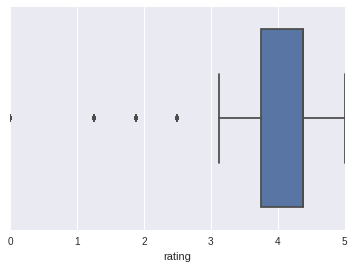

In [16]:
print(recipes.rating.describe())
__ = sb.boxplot(recipes.rating)

It appears that a good bifurcation point is 4.5 just above the 4th quartile.  

In [17]:
recipes['collapsedrating'] = np.where(recipes.rating < 4.5, 0, 1)
print('The amount of observations that are delicious: %d' % ((recipes.collapsedrating == 1).sum()))

# Lets remove the rating feature before we build the classifier
del recipes['rating']

The amount of observations that are delicious: 2106


After creating the new feature there are 2106 observations that are classified as delicious and 13,758 observations that are NOT delicious.  This gives an unbalanced dataset which is fine, good food is hard to come by. 

Lastly we scale the four nutritional features so that those features with greater ranges do not over influence the support vectors (their distance fro their peers across the decision boundary). 

In [18]:
from sklearn import preprocessing

# Scale our continuous data

min_max_scaler = preprocessing.MinMaxScaler()
recipes['calories_scaled'] = min_max_scaler.fit_transform(recipes.calories)
recipes['protein_scaled'] = min_max_scaler.fit_transform(recipes.protein)
recipes['fat_scaled'] = min_max_scaler.fit_transform(recipes.fat)
recipes['sodium_scaled'] = min_max_scaler.fit_transform(recipes.sodium)

# Remove the original features we don’t want them to be added our model, making our scaling useless 
recipes = recipes.drop(['calories', 'protein', 'fat', 'sodium'], 1)

## Model Building

In [19]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Function creates decision boundary plot and draws test samples if present 
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]                               
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
        
    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]   
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', 
                alpha=1.0, linewidth=1, marker='o', 
                s=55, label='test set')

In [28]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC

X = recipes.drop(['collapsedrating'], 1)
print('The number of observations is : %d and the number of features are: %d' % (X.shape[0], len(X.columns)))
y = recipes['collapsedrating']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

svm = SVC(C=1.0, random_state=0)
svm.fit(X_train, y_train)
#y_ = svm.predict(X_test)


print("\nAccuracy on training set: {:.3f}".format(svm.score(X_train, y_train)))
print("\nAccuracy on test set: {:.3f}".format(svm.score(X_test, y_test)))

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
#plot_decision_regions(X_combined, y_combined, classifier=svm)

#plt.xlabel('Delicious')
#plt.ylabel('Not Delicious')
#plt.legend(loc='upper left')
#plt.show()

The number of observations is : 15864 and the number of features are: 31

Accuracy on training set: 0.865

Accuracy on test set: 0.873
